In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import arrow
import matplotlib.pyplot as plt
from statistics import mean, median


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
import sys
# !{sys.executable} -m pip install arrow
# !{sys.executable} -m pip install -U scikit-learn
# !{sys.executable} -m pip install -U yellowbrick

## Project definition

Starbucks experimented with three types of offers: `buy-one-get-one (BOGO)`, `discount`, and `informational`. These are delivered through multiple channels and show different levels of "difficulty".

The experiment lasted one month and was meant to identify what characteristics of its customers are good predictors of the likelihood to "complete" an offer, that is spending over a certain amount in a defined period of time. 

This will be achieved with some first exploratory analytics and the implementation of a Random Forest Tree ML model.

0. [Problem statement](#problem_statement)<br/>
1. [Data loading and exploration](#data_loading_and_exploration)<br/>
2. [Data cleaning, feature engineering and first analyses](#data_cleaning_feature_engineering_and_first_analyses)<br/>
3. [Model](#Model)<br/>
4. [Final remarks](#final_remarks)<br/>

## Problem statement (from Udacity)
<a id='problem_statement'></a>

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks.

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer.

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

## Data loading and exploration
<a id='data_loading_and_exploration'></a>

`profile.json`<br/>
_Customers' data (17000 users x 5 fields)_<br/>

gender: (categorical) M, F, O, or null<br/>
age: (numeric) missing value encoded as 118<br/>
id: (string/hash)<br/>
became_member_on: (date) format YYYYMMDD<br/>
income: (numeric)<br/>


`portfolio.json`<br/>
_Offers sent during 30-day test period (10 offers x 6 fields)<br/>_

reward: (numeric) money awarded for the amount spent<br/>
channels: (list) web, email, mobile, social<br/>
difficulty: (numeric) money required to be spent to receive reward<br/>
duration: (numeric) time for offer to be open, in days<br/>
offer_type: (string) bogo, discount, informational<br/>
id: (string/hash)<br/>


`transcript.json`<br/>
_Event log (306648 events x 4 fields)_<br/>

person: (string/hash)<br/>
event: (string) offer received, offer viewed, transaction, offer completed<br/>
value: (dictionary) different values depending on event type<br/>
offer id: (string/hash) not associated with any "transaction"<br/>
amount: (numeric) money spent in "transaction"<br/>
reward: (numeric) money gained from "offer completed"<br/>
time: (numeric) hours after start of test<br/>

#### Portfolio

In [3]:
portfolio = pd.read_json('portfolio.json', orient='records', lines=True)
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


#### Profile

Total users: 17000


,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


/Users/saveriopertosa/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/saveriopertosa/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


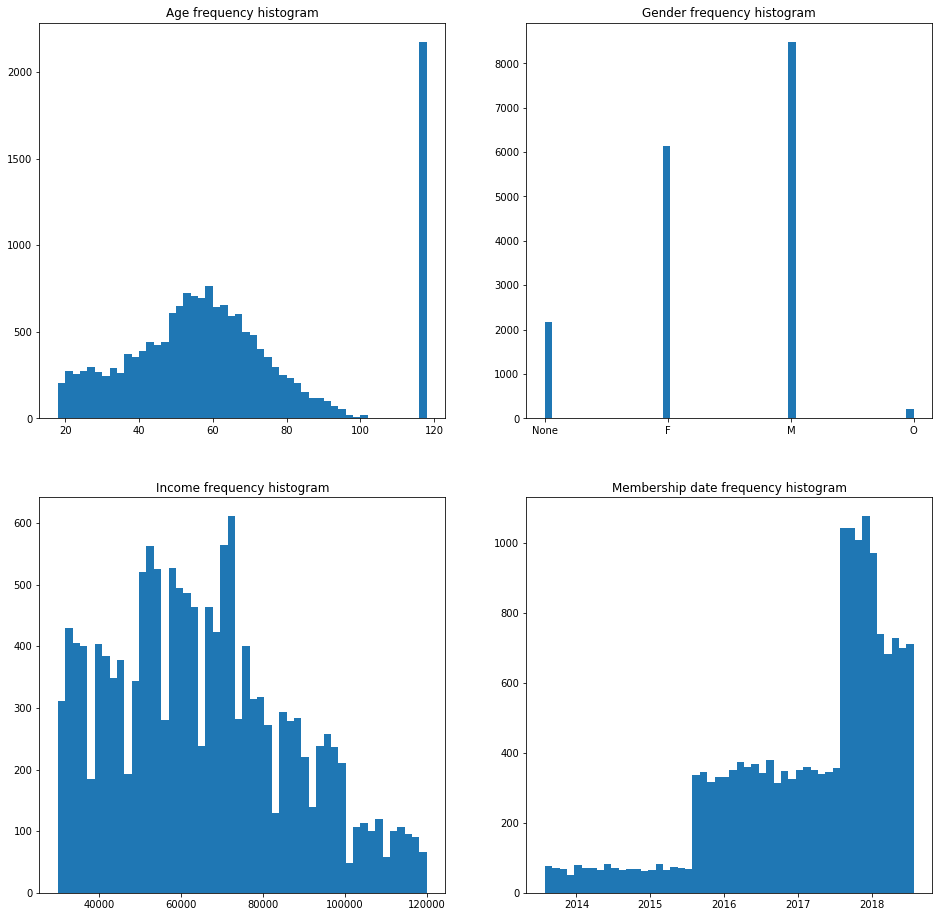

In [4]:
profile = pd.read_json('profile.json', orient='records', lines=True)
print(f"Total users: {profile.shape[0]}")

display(profile.head())
display(profile.describe())

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16,16))
ax0, ax1, ax2, ax3 = axes.flatten()

ax0.hist(profile.age, bins=50)
ax0.set_title('Age frequency histogram')
ax0.grid(False)

ax1.hist(profile.gender.astype('|S'), bins=50)
ax1.set_title('Gender frequency histogram')
ax1.grid(False)

ax2.hist(profile.income, bins=50)
ax2.set_title('Income frequency histogram')
ax2.grid(False)

ax3.hist(pd.to_datetime(profile.became_member_on, format='%Y%m%d'), bins=50)
ax3.set_title('Membership date frequency histogram')
ax3.grid(False)

In [5]:
print(f"Average age: {round(mean(profile[profile['age'] != 118]['age'].tolist()))}")
print(f"Average income: {round(mean(profile[pd.notna(profile['income'])]['income'].tolist()))}")
      
print(f"Median age: {round(median(profile[profile['age'] != 118]['age'].tolist()))}")
print(f"Median income: {round(median(profile[pd.notna(profile['income'])]['income'].tolist()))}")

Average age: 54
Average income: 65405
Median age: 55
Median income: 64000


These offers were sent mostly to customers who recently subscribed a membership to Starbucks, who are on average 54 years old and have a salary of about 65k $.
Both distributions are slightly skewed, but still average and median values are quite similar.

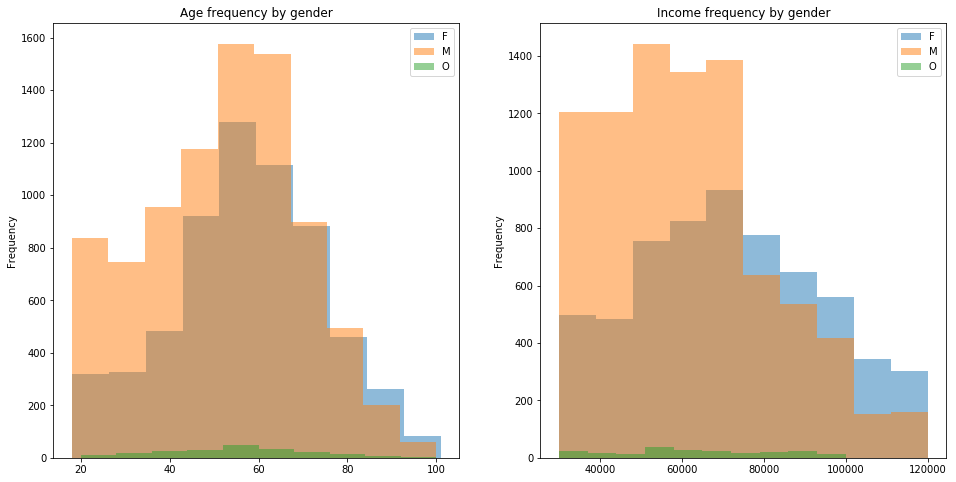

In [6]:
fig2, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,8))
ax0, ax1 = axes.flatten()

profile.groupby('gender').age.plot.hist(ax=ax0, alpha=0.5)
ax0.set_title('Age frequency by gender')
ax0.legend()
ax0.grid(False)


profile.groupby('gender').income.plot.hist(ax=ax1, alpha=0.5)
ax1.set_title('Income frequency by gender')
ax1.legend()
ax1.grid(False)

In [7]:
print(f"Average age by gender: {round(profile[profile['age'] != 118].groupby('gender')['age'].mean())}")
print(f"Average income by gender: {round(profile[pd.notna(profile['income'])].groupby('gender')['income'].mean())}")
      
print(f"Average age by gender: {round(profile[profile['age'] != 118].groupby('gender')['age'].median())}")
print(f"Average income by gender: {round(profile[pd.notna(profile['income'])].groupby('gender')['income'].median())}")

Average age by gender: gender
F    58.0
M    52.0
O    54.0
Name: age, dtype: float64
Average income by gender: gender
F    71306.0
M    61195.0
O    63288.0
Name: income, dtype: float64
Average age by gender: gender
F    58
M    53
O    55
Name: age, dtype: int64
Average income by gender: gender
F    71000.0
M    59000.0
O    62000.0
Name: income, dtype: float64


The gender-specific distributions of age and income have still similar average and median values.

On average female customers in the dataset both are older and have a higher income.



### Transcript

In [8]:
transcript = pd.read_json('transcript.json', orient='records', lines=True)

display(transcript.head())

tot_offers_received = transcript[transcript['event'] == 'offer received'].shape[0]
tot_offers_viewed = transcript[transcript['event'] == 'offer viewed'].shape[0]
tot_offers_completed = transcript[transcript['event'] == 'offer completed'].shape[0]
tot_transactions = transcript[transcript['event'] == 'transaction'].shape[0]

print(f"Total offers sent: {tot_offers_received}")
print(f"Total offers viewed: {tot_offers_viewed}")
print(f"Total offers completed: {tot_offers_completed}")
print(f"Total transactions: {tot_transactions}")
print("")
print(f"High-level % of opened offers: {round(tot_offers_viewed/tot_offers_received,4)*100}%")
print(f"High-level % of completed offers: {round(tot_offers_completed/tot_offers_received,4)*100}%")
print(f"High-level % of completed offers, if viewed: {round(tot_offers_completed/tot_offers_viewed,4)*100} %")

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


Total offers sent: 76277
Total offers viewed: 57725
Total offers completed: 33579
Total transactions: 138953

High-level % of opened offers: 75.68%
High-level % of completed offers: 44.019999999999996%
High-level % of completed offers, if viewed: 58.17 %


## Data cleaning, feature engineering and first analyses
<a id='data_cleaning_feature_engineering_and_first_analyses'></a>

#### First cleansing

In [9]:
# Replace missing values' encoded `118` with nan
profile['age'].replace(118, np.nan, inplace=True)

# Relpace None with nan
profile.replace([None], np.nan, inplace=True)

# Apply arrow-style formatting to membership dates, and then take the difference in days to 1970-01-01 to convert column in integers
profile['became_member_on'] = profile['became_member_on'].apply(lambda x: arrow.get(str(x), 'YYYYMMDD'))
profile['became_member_on'] = profile['became_member_on'].apply(lambda x: (x - arrow.get('2013-01-01', 'YYYY-MM-DD')).days)

# Convert `Gender` from Object to string
profile['gender'] = profile['gender'].astype('|S')

#### Data transformation via JOINs
In the next cells we will JOIN all dataframes to have a single source of data. On top of it, we'll perform feature engineering.

In [10]:
transcript_with_profile = transcript.merge(profile, left_on='person', right_on='id').drop('id', axis=1)

def get_complete_df():
    """
    The function builds the entire dataframe and caches it by saving a .csv
    """
    
    # Transform the values of the `value` column into separate columns
    transcript_with_profile_augmented = pd.concat([transcript_with_profile.drop('value', axis=1),
                                                   transcript_with_profile['value'].apply(pd.Series)], axis=1)

    # Coalesce `offer_id` and `offer id`
    transcript_with_profile_augmented['offer_id'] = transcript_with_profile_augmented['offer_id'].combine_first(transcript_with_profile_augmented['offer id'])
    transcript_with_profile_augmented.drop('offer id', axis=1, inplace=True)

    # Complpete dataframe
    df = transcript_with_profile_augmented.drop('reward', axis=1).merge(portfolio, left_on='offer_id', right_on='id', how='left').drop('id', axis=1)

    # Convert the list of channels into boolean columns
    for channel in ['web', 'email', 'mobile', 'social']:
        df[channel] = df['channels'].apply(lambda x: channel in str(x))

    df.drop('channels', axis=1)
    
    df.to_csv('joined_data.csv')

In [11]:
# Try to load the dataframe from the cache, otherwise build it

try:
    df = pd.read_csv('joined_data.csv')
    df.drop(df.columns[0], axis=1, inplace=True)
    print("Dataframe loaded from the cache")
except:
    get_complete_df()
    df = pd.read_csv('joined_data.csv')
    df.drop(df.columns[0], axis=1, inplace=True)
    print("Datarame created and cached")

Dataframe loaded from the cache


To build the model that will map customers' features to the probability of completing an offer, the first step is to make the Dataframe _pivot-like_, with every row representing an offer sent to a specific customer.

For the time being, I will thus ignore all transactions that occured outside the context of an offer. They will be, however, used later to build a new feature. 

In [12]:
df_no_standalone_transactions = df[df['event'] != 'transaction']
df_no_standalone_transactions.head()

,event,person,time,age,became_member_on,gender,income,amount,offer_id,channels,difficulty,duration,offer_type,reward,web,email,mobile,social
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,75.0,1589,b'F',100000.0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,"['web', 'email', 'mobile']",5.0,7.0,bogo,5.0,True,True,True,False
1,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,75.0,1589,b'F',100000.0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,"['web', 'email', 'mobile']",5.0,7.0,bogo,5.0,True,True,True,False
3,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,75.0,1589,b'F',100000.0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,"['web', 'email', 'mobile']",5.0,7.0,bogo,5.0,True,True,True,False
5,offer received,78afa995795e4d85b5d9ceeca43f5fef,168,75.0,1589,b'F',100000.0,NaN,5a8bc65990b245e5a138643cd4eb9837,"['email', 'mobile', 'social']",0.0,3.0,informational,0.0,False,True,True,True
6,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,216,75.0,1589,b'F',100000.0,NaN,5a8bc65990b245e5a138643cd4eb9837,"['email', 'mobile', 'social']",0.0,3.0,informational,0.0,False,True,True,True


The following cell is meant to build to two boolean columns showing if an offer was wieved and completed.

Then, only rows with the event `offer received` are kept.

In [13]:
df_no_standalone_transactions['event_lagged'] = df.sort_values(by='time').groupby(['person', 'offer_id'])['event'].shift(-1)
df_no_standalone_transactions['event_lagged_2'] = df.sort_values(by='time').groupby(['person', 'offer_id'])['event'].shift(-2)
df_no_standalone_transactions_pivot = df_no_standalone_transactions[df_no_standalone_transactions['event'] == 'offer received']
df_no_standalone_transactions_pivot.head()

,event,person,time,age,became_member_on,gender,income,amount,offer_id,channels,difficulty,duration,offer_type,reward,web,email,mobile,social,event_lagged,event_lagged_2
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,75.0,1589,b'F',100000.0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,"['web', 'email', 'mobile']",5.0,7.0,bogo,5.0,True,True,True,False,offer viewed,offer completed
5,offer received,78afa995795e4d85b5d9ceeca43f5fef,168,75.0,1589,b'F',100000.0,NaN,5a8bc65990b245e5a138643cd4eb9837,"['email', 'mobile', 'social']",0.0,3.0,informational,0.0,False,True,True,True,offer viewed,NaN
10,offer received,78afa995795e4d85b5d9ceeca43f5fef,408,75.0,1589,b'F',100000.0,NaN,ae264e3637204a6fb9bb56bc8210ddfd,"['email', 'mobile', 'social']",10.0,7.0,bogo,10.0,False,True,True,True,offer completed,NaN
12,offer received,78afa995795e4d85b5d9ceeca43f5fef,504,75.0,1589,b'F',100000.0,NaN,f19421c1d4aa40978ebb69ca19b0e20d,"['web', 'email', 'mobile', 'social']",5.0,5.0,bogo,5.0,True,True,True,True,offer completed,offer viewed
18,offer received,a03223e636434f42ac4c3df47e8bac43,0,NaN,1676,b'nan',NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,"['web', 'email']",20.0,10.0,discount,5.0,True,True,False,False,offer viewed,offer received


The transactions that happened outside the context of an `offer completed` event are those that were not "triggered" by any offer.

A way to easily identify them is by excluding all those purchases that, for a given value of `(person, time)`, are assigned to an event `offer completed` in the `transaction` table.

These transactions are a proxy of a customer's natural tendency to buy Starbucks products, and the total amount of them will be used as a feature. Since we are excluding purchases triggered by an offer, we are not risking any data leakege problem.

In [14]:
# Create a new dataframe with the total number of transaction per customer
transaction = df[df['event'] == 'transaction'][['person', 'time']]
offer_completed = df[df['event'] == 'offer completed'][['person', 'time']]

transaction_set = set([tuple(line) for line in transaction.values])
offer_completed_set = set([tuple(line) for line in offer_completed.values])

all_transaction_no_offer_completed = pd.DataFrame(list(transaction_set.difference(offer_completed_set)), columns=['person', 'purchases'])
all_transaction_no_offer_completed_count = all_transaction_no_offer_completed.groupby(['person']).count().reset_index()

# Create the new feature column by JOINinig the main Dataframe and the newly created one
df_no_standalone_transactions_pivot = df_no_standalone_transactions_pivot.merge(all_transaction_no_offer_completed_count, on='person', how='left')

#### Labeling

We want two categorical output variables

- **Y1** - 4 labels - variable name `granular category`

0: Viewed the offer + Completed the offer<br/>
1: Viewed the offer + Did not complete the offer<br/>
2: Did not view the offer + Completed the offer (this includes the cases in which a customer first completes the offer, and then views it)<br/>
3: Did not view the offer + Did not complete the offer<br/>

- **Y2** - 2 labels - variable name `category`

0: Customer completed a specific offer being _influenced by it_ (equal to the previous label 0)<br/>
1: All other cases (equal to the previous labels 1-2-3)

In [15]:
def apply_granular_label(row):
    """
    For an "offer received" event, the function will attribute it to one of the 4 Y1's labels
    """
    if (row['event_lagged'] == 'offer viewed') & (row['event_lagged_2'] == 'offer completed'):
        return 0
    elif row['event_lagged'] == 'offer viewed':
        return 1
    elif row['event_lagged'] == 'offer completed':
        return 2
    else:
        return 3

df_no_standalone_transactions_pivot['granular_category'] = df_no_standalone_transactions_pivot.apply(apply_granular_label, axis=1)
df_no_standalone_transactions_pivot['category'] = (df_no_standalone_transactions_pivot['granular_category'] > 0).apply(int)

df_no_standalone_transactions_pivot.head()

,event,person,time,age,became_member_on,gender,income,amount,offer_id,channels,difficulty,duration,offer_type,reward,web,email,mobile,social,event_lagged,event_lagged_2,purchases,granular_category,category
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,75.0,1589,b'F',100000.0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,"['web', 'email', 'mobile']",5.0,7.0,bogo,5.0,True,True,True,False,offer viewed,offer completed,5.0,0,0
1,offer received,78afa995795e4d85b5d9ceeca43f5fef,168,75.0,1589,b'F',100000.0,NaN,5a8bc65990b245e5a138643cd4eb9837,"['email', 'mobile', 'social']",0.0,3.0,informational,0.0,False,True,True,True,offer viewed,NaN,5.0,1,1
2,offer received,78afa995795e4d85b5d9ceeca43f5fef,408,75.0,1589,b'F',100000.0,NaN,ae264e3637204a6fb9bb56bc8210ddfd,"['email', 'mobile', 'social']",10.0,7.0,bogo,10.0,False,True,True,True,offer completed,NaN,5.0,2,1
3,offer received,78afa995795e4d85b5d9ceeca43f5fef,504,75.0,1589,b'F',100000.0,NaN,f19421c1d4aa40978ebb69ca19b0e20d,"['web', 'email', 'mobile', 'social']",5.0,5.0,bogo,5.0,True,True,True,True,offer completed,offer viewed,5.0,2,1
4,offer received,a03223e636434f42ac4c3df47e8bac43,0,NaN,1676,b'nan',NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,"['web', 'email']",20.0,10.0,discount,5.0,True,True,False,False,offer viewed,offer received,3.0,1,1


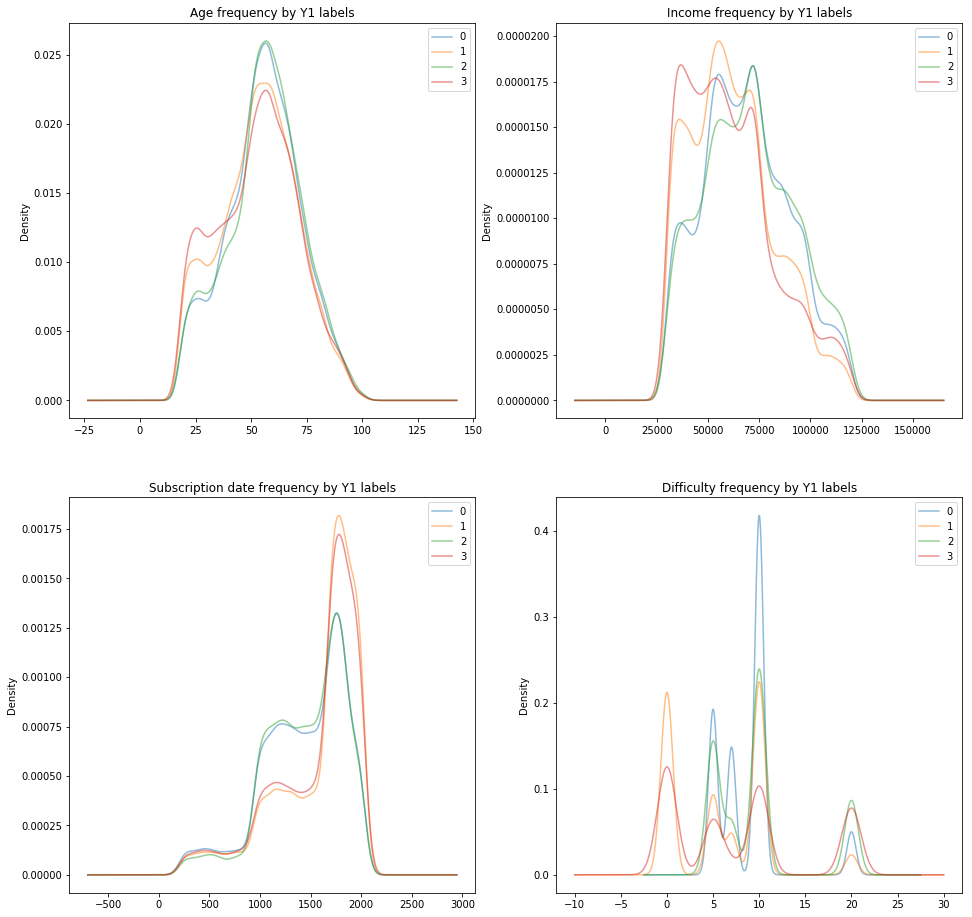

In [16]:
fig4, axes = plt.subplots(nrows=2, ncols=2, figsize=(16,16))
ax0, ax1, ax2, ax3, = axes.flatten()

df_no_standalone_transactions_pivot.groupby('granular_category').age.plot.density(ax=ax0, alpha=0.5)
ax0.set_title('Age frequency by Y1 labels')
ax0.legend()
ax0.grid(False)

df_no_standalone_transactions_pivot.groupby('granular_category').income.plot.density(ax=ax1, alpha=0.5)
ax1.set_title('Income frequency by Y1 labels')
ax1.legend()
ax1.grid(False)

df_no_standalone_transactions_pivot.groupby('granular_category').became_member_on.plot.density(ax=ax2, alpha=0.5)
ax2.set_title('Subscription date frequency by Y1 labels')
ax2.legend()
ax2.grid(False)

df_no_standalone_transactions_pivot.groupby('granular_category').difficulty.plot.density(ax=ax3, alpha=0.5)
ax3.set_title('Difficulty frequency by Y1 labels')
ax3.legend()
ax3.grid(False)

Some first interesting insights:
- Younger people tend to neither view nor complete the offer
- Income is positively correlated with the likelihood of completing the offer (regardless of actually seeing the offer). This is of course a consequence of the higher purchasing power/lower price sensitivity
- Interestingly enough, the longer the customer has been a member, the lower the chance that they will complete an offer.
- Most of the viewed-completed offers had an average (10) difficulty.

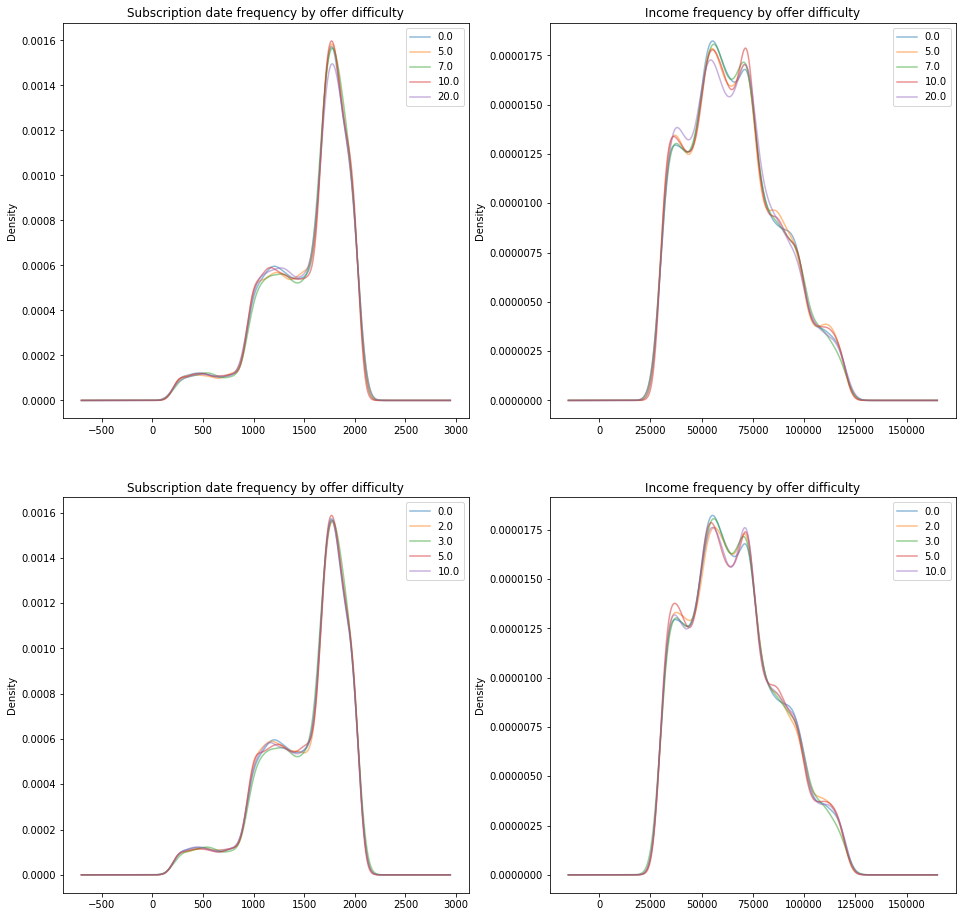

In [17]:
fig5, axes = plt.subplots(nrows=2, ncols=2, figsize=(16,16))
ax0, ax1, ax2, ax3 = axes.flatten()

df_no_standalone_transactions_pivot.groupby('difficulty').became_member_on.plot.density(ax=ax0, alpha=0.5)
ax0.set_title('Subscription date frequency by offer difficulty')
ax0.legend()
ax0.grid(False)

df_no_standalone_transactions_pivot.groupby('difficulty').income.plot.density(ax=ax1, alpha=0.5)
ax1.set_title('Income frequency by offer difficulty')
ax1.legend()
ax1.grid(False)

df_no_standalone_transactions_pivot.groupby('reward').became_member_on.plot.density(ax=ax2, alpha=0.5)
ax2.set_title('Subscription date frequency by offer difficulty')
ax2.legend()
ax2.grid(False)

df_no_standalone_transactions_pivot.groupby('reward').income.plot.density(ax=ax3, alpha=0.5)
ax3.set_title('Income frequency by offer difficulty')
ax3.legend()
ax3.grid(False)

It's curious to see that the difficulty and the reward of offers don't depend on those variables that most correlated with the probability of completing an offer: income and membership duration.

It would be interesting to experiment with offers having a level of difficulty customized on users' features.

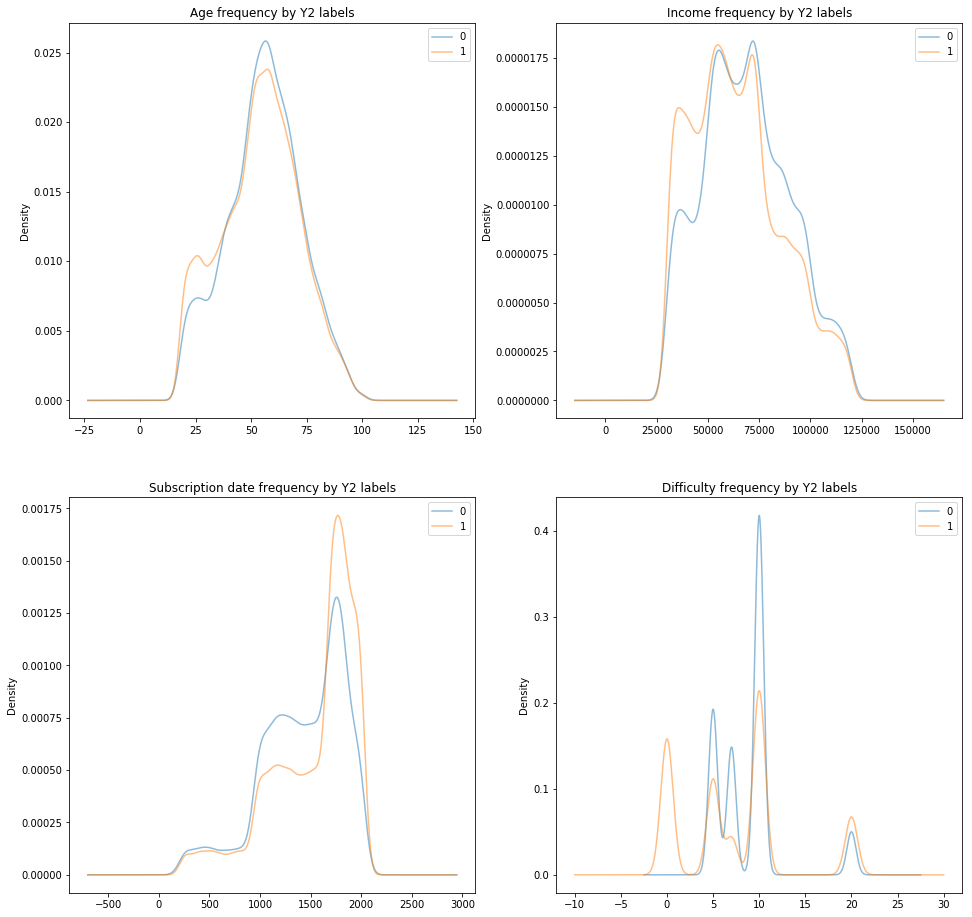

In [18]:
fig4, axes = plt.subplots(nrows=2, ncols=2, figsize=(16,16))
ax0, ax1, ax2, ax3 = axes.flatten()

df_no_standalone_transactions_pivot.groupby('category').age.plot.density(ax=ax0, alpha=0.5)
ax0.set_title('Age frequency by Y2 labels')
ax0.legend()
ax0.grid(False)

df_no_standalone_transactions_pivot.groupby('category').income.plot.density(ax=ax1, alpha=0.5)
ax1.set_title('Income frequency by Y2 labels')
ax1.legend()
ax1.grid(False)

df_no_standalone_transactions_pivot.groupby('category').became_member_on.plot.density(ax=ax2, alpha=0.5)
ax2.set_title('Subscription date frequency by Y2 labels')
ax2.legend()
ax2.grid(False)

df_no_standalone_transactions_pivot.groupby('category').difficulty.plot.density(ax=ax3, alpha=0.5)
ax3.set_title('Difficulty frequency by Y2 labels')
ax3.legend()
ax3.grid(False)

The density distributions with Y1 labeling provide similar information to what was highlighted before.

Of course, we expect the model being more precise with this binary-labeling.

#### Correlation matrix

In [19]:
FEATURE_LIST = [
    'time',
    'age',
    'became_member_on',
    'gender',
    'income',
    'difficulty',
#     'duration',
    'offer_type',
    'reward',
    'web',
#     'email',
    'mobile',
    'social',
    'purchases'
]

df_no_standalone_transactions_pivot[FEATURE_LIST].corr().abs().round(2)

,time,age,became_member_on,income,difficulty,reward,web,mobile,social,purchases
time,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01
age,0.00,1.00,0.01,0.31,0.00,0.00,0.00,0.00,0.00,0.20
became_member_on,0.00,0.01,1.00,0.02,0.00,0.00,0.00,0.00,0.00,0.38
income,0.00,0.31,0.02,1.00,0.00,0.00,0.00,0.00,0.00,0.35
difficulty,0.00,0.00,0.00,0.00,1.00,0.47,0.24,0.74,0.16,0.00
reward,0.00,0.00,0.00,0.00,0.47,1.00,0.12,0.08,0.29,0.01
web,0.00,0.00,0.00,0.00,0.24,0.12,1.00,0.17,0.41,0.01
mobile,0.00,0.00,0.00,0.00,0.74,0.08,0.17,1.00,0.41,0.03
social,0.00,0.00,0.00,0.00,0.16,0.29,0.41,0.41,1.00,0.05
purchases,0.01,0.20,0.38,0.35,0.00,0.01,0.01,0.03,0.05,1.00


The features have overall low correlation values to one another, and thus none will be excluded from the analysis.

`Duration` and `email` have been excluded since the first is not an information that would be directly available in the context of the next marketing campaign, and the second is not informative having a constant value.

## Model
<a id='model'></a>

Decision Trees are robust to outliers, since they are able to segregate unusually large or small observations into smaller leaves. Thus extreme values do not affect the model globally.

Also, feature rescaling is not necessary with Random Forest, since Tree-based models do not take into account the absolute values, but only their order.

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, plot_confusion_matrix, recall_score, precision_score
from yellowbrick.classifier import ROCAUC

def split_data(label, test_size, split_random_state):
    """
    Given a label between `granular category` and `category`, the function will 
    - encode categorical features as integers,
    - fill null values with the column's mean
    - perform the train test split
    It will then return the split data
    """
    
    X = df_no_standalone_transactions_pivot[FEATURE_LIST]
    lb = LabelEncoder()
    offer_type_labels = lb.fit_transform(X['offer_type'])
    X['offer_type'] = offer_type_labels
    gender_labels = lb.fit_transform(X['gender'])
    X['gender'] = gender_labels
    
    X.fillna(X.mean(), inplace=True)

    Y = df_no_standalone_transactions_pivot[label]

    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=split_random_state, stratify=Y)

    return X_train, X_test, y_train, y_test    
    

def model_fit(label, X_train, y_train, model_random_state):
    """
    Given a label between `granular category` and `category`, the function will return the fitted model.
    The specific hyperparameters were chosen with a GridSearch on the space made by
        n_estimators = [100, 300, 500, 800, 1200]
        max_depth = [5, 8, 15, 25, 30]
        min_samples_split = [2, 5, 10, 15, 100]
        min_samples_leaf = [1, 2, 5, 10]
    """
    
    if label == 'granular_category':
        hyperparams = {
            'max_depth': 15,
            'min_samples_leaf': 10,
            'min_samples_split': 2,
            'n_estimators': 800
        }
        
    elif label == 'category':
        hyperparams = {
            'max_depth': 15,
            'min_samples_leaf': 10,
            'min_samples_split': 2,
            'n_estimators': 100
        }
    
    rfc = RandomForestClassifier(**hyperparams,
                                 random_state=model_random_state)

    fitted_rfc = rfc.fit(X_train, y_train)
    
    return fitted_rfc
    
def print_performance_metrics(label, fitted_rfc, X_train, y_train, X_test, y_test):
    """
    Prints some performance metrics
    - Accuracy
    - Balanced accuracy
    - Confusion matrix
    - ROC curve
    """
    
    # Accuracies
    print(f"The accuracy of the model is: {round(fitted_rfc.score(X_test, y_test),2)}")
    print(f"The balanced accuracy is: {round(balanced_accuracy_score(y_test, fitted_rfc.predict(X_test)),2)}")
    print(f"The weighted recall is: {round(recall_score(y_test, fitted_rfc.predict(X_test), average='weighted'),2)}")
    print(f"The weighted precision is: {round(precision_score(y_test, fitted_rfc.predict(X_test), average='weighted'),2)}")
    
    # Confusion matrix
    conf_mat = confusion_matrix(y_test, fitted_rfc.predict(X_test))
    titles_normalization = [("Confusion matrix, without normalization", None), ("Normalized confusion matrix", 'true')]

    for title, normalization in titles_normalization:
        disp = plot_confusion_matrix(fitted_rfc, X_test, y_test,
                                     cmap=plt.cm.Blues,
                                     normalize=normalization,
                                     xticks_rotation='vertical'
                                    )
        disp.ax_.set_title(title)
        plt.show()
    
    # ROC curve
    visualizer = ROCAUC(fitted_rfc)
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    visualizer.show()  
    
def feature_importance(fitted_rfc, X_test):
    """
    Prints and plots the ranking of features' importance
    """
    importances = fitted_rfc.feature_importances_
    df_importances = pd.DataFrame({'feature': list(X_test.columns), 'importance': fitted_rfc.feature_importances_})
    df_importances.sort_values('importance', ascending=False, inplace=True)

    # Print the feature ranking
    print("Feature ranking:")
    print(df_importances)
    
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(X_test.shape[1]), df_importances['importance'],
            color="r", align="center")
    plt.xticks(range(X_test.shape[1]), df_importances['feature'], rotation='vertical')
    plt.xlim([-1, X_test.shape[1]])
    plt.show()

def main(label, test_size=0.2, split_random_state=42, model_random_state=1):
    X_train, X_test, y_train, y_test = split_data(label, test_size, split_random_state)
    fitted_rfc = model_fit(label, X_train, y_train, model_random_state)
    
    print_performance_metrics(label, fitted_rfc, X_train, y_train, X_test, y_test)
    feature_importance(fitted_rfc, X_test)

Some performance metrics are shown for each model

##### Accuracy
`The set of labels predicted for a sample must exactly match the corresponding set of labels in y_true.`

_reference_: [Sklearn accuracy_score documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)

##### Balanced accuracy
`The balanced accuracy in binary and multiclass classification problems to deal with imbalanced datasets. It is defined as the average of recall obtained on each class.`

_reference_: [Sklearn balanced_accuracy_score documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html)

##### Recall and precision
`The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.`

`The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative`

_reference_: [Sklearn precision_recall_fscore_support documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html)

##### Confusion matrix
`Each row of the matrix represents the instances in a predicted class while each column represents the instances in an actual class.`

_reference_: [Wikipedia page "Confusion matrix"](https://en.wikipedia.org/wiki/Confusion_matrix)


##### ROCAUC
`A ROCAUC (Receiver Operating Characteristic/Area Under the Curve) plot allows the user to visualize the tradeoff between the classifier’s sensitivity and specificity.`

_reference_: [Yellowbrick ROCAUC documentation](https://www.scikit-yb.org/en/latest/api/classifier/rocauc.html)

## First model: Y1 - 4 labels

The accuracy of the model is: 0.57
The balanced accuracy is: 0.53
The weighted recall is: 0.57
The weighted precision is: 0.56


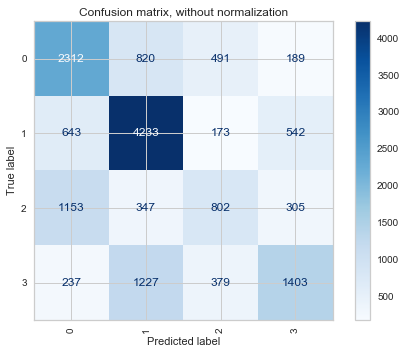

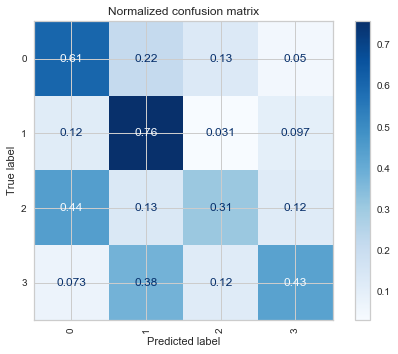

/Users/saveriopertosa/anaconda3/lib/python3.7/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


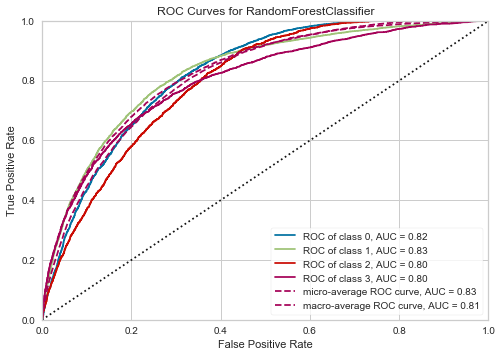

Feature ranking:
             feature  importance
2   became_member_on    0.170847
4             income    0.127416
10            social    0.112051
7             reward    0.094167
11         purchases    0.089937
5         difficulty    0.084200
3             gender    0.083577
1                age    0.075994
6         offer_type    0.074731
0               time    0.040881
8                web    0.031968
9             mobile    0.014232


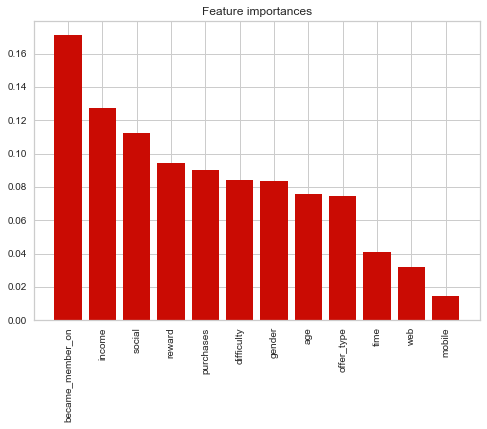

In [21]:
main('granular_category')

## First model: Y2 - 2 labels

The accuracy of the model is: 0.78
The balanced accuracy is: 0.65
The weighted recall is: 0.78
The weighted precision is: 0.76


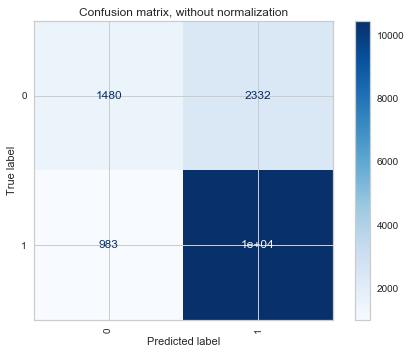

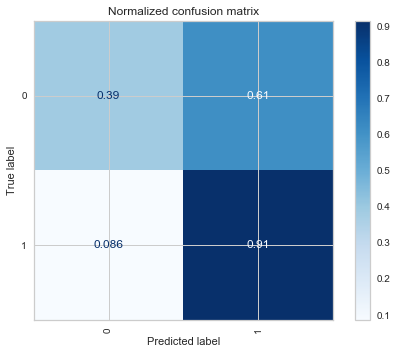

/Users/saveriopertosa/anaconda3/lib/python3.7/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


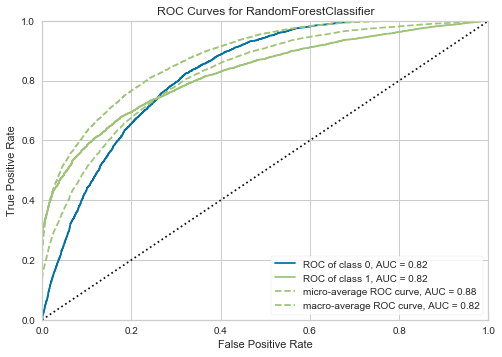

Feature ranking:
             feature  importance
2   became_member_on    0.180499
7             reward    0.124108
4             income    0.119704
5         difficulty    0.101462
6         offer_type    0.094114
11         purchases    0.089057
1                age    0.079343
10            social    0.077489
3             gender    0.074851
0               time    0.034939
8                web    0.015200
9             mobile    0.009234


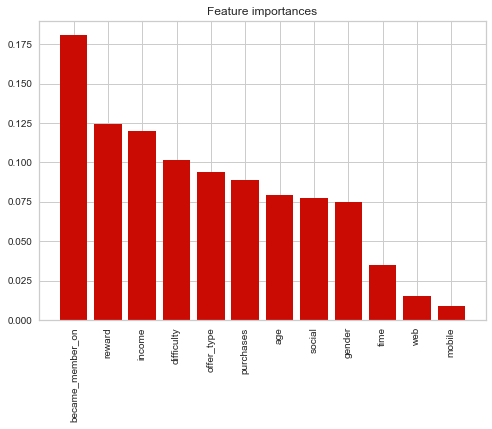

In [22]:
main('category')

As a final step, we compare the accuracy score obtained the RFC with those obtained with a non-optimized `Decision Tree` classifier model, with non optimized hyperparameters and that will not use the `purchases` field.

In [23]:
from sklearn.tree import DecisionTreeClassifier

def benchmark(label, test_size=0.2, split_random_state=42, model_random_state=1):
    """
    Given a label between `granular category` and `category`, the function will return the fitted benchmark model.
    """
    
    X_train, X_test, y_train, y_test = split_data(label, test_size, split_random_state)
    
    X_train.drop("purchases", axis=1, inplace=True)
    X_test.drop("purchases", axis=1, inplace=True)
    
    dtc = DecisionTreeClassifier(random_state=model_random_state)

    fitted_dtc = dtc.fit(X_train, y_train)
    
    print(f"The accuracy of the model is: {round(fitted_dtc.score(X_test, y_test),2)}")

In [24]:
benchmark("granular_category")

The accuracy of the model is: 0.44


In [25]:
benchmark("category")

The accuracy of the model is: 0.71


## Final remarks
<a id='final_remarks'></a>

The final model achieved a good performance in accurately identifying those features that most correlate with customers completing offers. 

In particular:
- `Mobile` and `web` channels have low impact in offer completion rates. `Social networks` seem to be the best channel, thus other marketing activities (e.g. influencer marketing) on these websites are advised.
- The `membership` duration is important, but the direction of the impact is non-obvious, since older members are less prone to complete offers than newer. This might be a consequence of older members having experimented more of Starbuck's catalog and thus being less responsive to offers. It would be interesting to customize the difficulty/reward combinations for `membership` length.
- Monetary variables, i.e. `reward`, `income` and `frequency`, are strongly correlated with the probability of completing the offer. Still, right now Starbucks is not differentiating the kind of offers based on customers' `income`. This could be a succesful strategy to test out in future.